In [ ]:
import tensorflow as tf

In [ ]:
!hostname

In [ ]:
!nvidia-smi

In [ ]:
memory=7.0
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_virtual_device_configuration(gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory*1024)])
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

In [ ]:
tf.__file__

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
# standard library imports
from __future__ import absolute_import, division, print_function
import tensorflow as tf
print(tf.__version__)

In [ ]:
from tensorflow.keras.layers import Lambda, Dense, Input, Layer, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.initializers import Constant
from tensorflow.keras.backend import concatenate

# standard numerical library imports
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt

In [ ]:
# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

In [ ]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager
'''rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22) 
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 
rc('legend', fontsize=15) '''

In [11]:
# Path to downloaded data from Zenodo
data_dir = '/nfs/dust/cms/user/vaguglie/generators/pythia8307/examples/'

In [12]:
dataset = np.load(data_dir + 'Xb_multC_multNeutra_listBtop_listBextra-Rb_1.056_1M_seed3_CP5.npz')
print(dataset.files)
X0 = dataset['a']

['a', 'b', 'c', 'd', 'e']


In [13]:
dataset = np.load(data_dir + 'Xb_multC_multNeutra_listBtop_listBextra-Rb_0.855_1M_seed3_CP5.npz')
print(dataset.files)
X1 = dataset['a']

['a', 'b', 'c', 'd', 'e']


In [14]:
print(X0.shape)
print(X1.shape)

(1992844,)
(1992664,)


In [15]:
X0 = X0[0:1900000]
X1 = X1[0:1900000]

In [16]:
X0_pari = []
X0_dispari = []
X1_pari = []
X1_dispari = []
for i in range (0, 1900000):
    if i % 2 == 0:
        X0_pari.append(X0[i])
        X1_pari.append(X1[i])
    else:
        X0_dispari.append(X0[i])
        X1_dispari.append(X1[i])

In [17]:
print(len(X0_pari))
print(len(X1_pari))

950000
950000


In [18]:
print(len(X0_dispari))
print(len(X1_dispari))

950000
950000


In [19]:
X0_tot = []
for i in range (0, 950000):
    X0_tot.append([[X0_pari[i]], [X0_dispari[i]]])

In [20]:
X0_tot = np.array(X0_tot)

In [93]:
print(X0_tot)

[[[0.76128528]
  [0.62331721]]

 [[0.74188889]
  [0.53321759]]

 [[0.81918905]
  [0.81031954]]

 ...

 [[0.9676932 ]
  [0.25211707]]

 [[0.48189472]
  [0.69064323]]

 [[0.85315972]
  [0.66344894]]]


In [94]:
X1_tot = []
for i in range (0, 950000):
    X1_tot.append([[X1_pari[i]], [X1_dispari[i]]])

In [95]:
X1_tot = np.array(X1_tot)

In [96]:
print(X1_tot)

[[[0.80738807]
  [0.63293768]]

 [[0.89015645]
  [0.53905544]]

 [[0.42713191]
  [0.91447767]]

 ...

 [[0.99293596]
  [0.76236092]]

 [[0.94031114]
  [0.4092653 ]]

 [[0.95087903]
  [0.81287248]]]


In [97]:
print(X0_tot.shape)
print(X1_tot.shape)

(950000, 2, 1)
(950000, 2, 1)


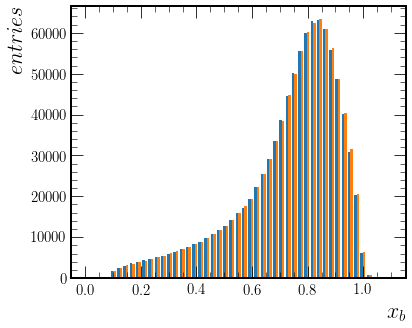

In [98]:
# xb X0
plt.figure(figsize=(6,5))
bins = np.linspace(0,1.1,50)
hist0 = plt.hist(X0_tot[:,:,0], bins = bins)


plt.xlabel(r'$x_b$')
plt.ylabel('$entries$')
#plt.yscale('log')
plt.show()

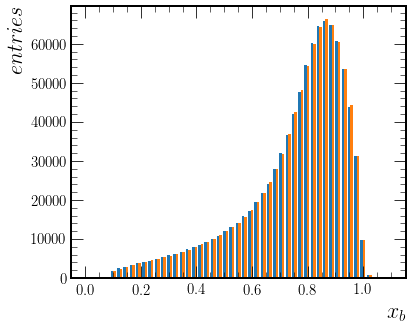

In [99]:
# xb X1
plt.figure(figsize=(6,5))
bins = np.linspace(0,1.1,50)
hist0 = plt.hist(X1_tot[:,:,0], bins = bins)


plt.xlabel(r'$x_b$')
plt.ylabel('$entries$')
#plt.yscale('log')
plt.show()

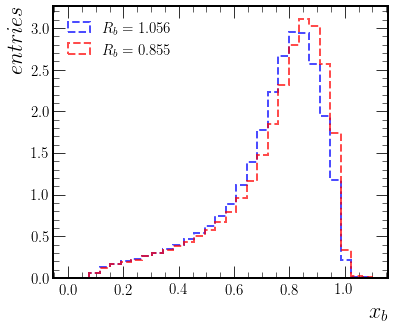

In [100]:
# xb
plt.figure(figsize=(6,5))
bins = np.linspace(0,1.1,30)
plot_style_0 = {'histtype':'step', 'color':'blue', 'linewidth':2, 'linestyle':'--', 'density':True}
plot_style_1 = {'histtype':'step', 'color':'red', 'linewidth':2, 'linestyle':'--', 'density':True}
plot_style_2 = {'histtype':'step', 'color':'green', 'linewidth':2, 'linestyle':'--', 'density':True}
plot_style_3 = {'histtype':'step', 'color':'orange', 'linewidth':2, 'linestyle':'--', 'density':True}
hist0 = plt.hist(X0_tot[:,0,0], bins = bins, alpha=0.7, label = r'$R_b = 1.056$', **plot_style_0)
hist1 = plt.hist(X1_tot[:,0,0], bins = bins, alpha=0.7, label = r'$R_b = 0.855$', **plot_style_1)

plt.xlabel(r'$x_b$')
plt.ylabel('$entries$')
#plt.yscale('log')
plt.legend(loc='upper left')
plt.show()

In [101]:
Y0 = np.array([0. for i in range(X0_tot.shape[0])])
Y1 = np.array([1. for i in range(X1_tot.shape[0])])

print(Y0.shape)
print(Y1.shape)

(950000,)
(950000,)


In [102]:
print(Y0)
print(Y1)

[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]


In [103]:
X0 = X0_tot
X1 = X1_tot

In [104]:
Y = np.concatenate((Y0, Y1))
X = np.concatenate((X0, X1))
Y = to_categorical(Y, num_classes=2)
print(X.shape)
print(Y.shape)

(1900000, 2, 1)
(1900000, 2)


In [105]:
X_train, X_val, Y_train, Y_val = data_split(X, Y, test=0.1, shuffle=True) 

In [106]:
print(X_train.shape)
print(Y_train.shape)

print(X_val.shape)
print(Y_val.shape)

(1710000, 2, 1)
(1710000, 2)
(190000, 2, 1)
(190000, 2)


In [107]:
print(X0.shape)
print(X1.shape)

(950000, 2, 1)
(950000, 2, 1)


In [108]:
# network architecture parameters
Phi_sizes = (100,100,128)
F_sizes = (100,100,100)

dctr = PFN(input_dim=1, 
           Phi_sizes=Phi_sizes, F_sizes=F_sizes,
           summary=False)

In [109]:
from tensorflow import keras 

In [110]:
save_label = 'DCTR_pp_tt_1D_Rb_mine_xB_CP5_nominal'

checkpoint = keras.callbacks.ModelCheckpoint('/afs/desy.de/user/v/vaguglie/saved_models_Rb/' + save_label + '.h5', 
                                                monitor='val_loss', 
                                                verbose=2, 
                                                save_best_only=True, 
                                                mode='min')

CSVLogger = keras.callbacks.CSVLogger('/afs/desy.de/user/v/vaguglie/logs_Rb/' + save_label + '_loss.csv', append=False)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta=0, 
                                              patience=10, 
                                              verbose=1, 
                                              restore_best_weights=True)

callbacks = [checkpoint, CSVLogger, EarlyStopping]

In [111]:
history = dctr.fit(X_train, Y_train,
                    epochs = 100,
                    batch_size = 1000,
                    validation_data = (X_val, Y_val),
                    verbose = 1, 
                    callbacks = callbacks)

Epoch 1/100
1710/1710 [==============================] - 8s 4ms/step - loss: 0.6954 - acc: 0.5097 - val_loss: 0.6904 - val_acc: 0.5370

Epoch 00001: val_loss improved from inf to 0.69043, saving model to /afs/desy.de/user/v/vaguglie/saved_models_Rb/DCTR_pp_tt_1D_Rb_mine_xB_CP5_nominal.h5
Epoch 2/100
1710/1710 [==============================] - 6s 4ms/step - loss: 0.6883 - acc: 0.5432 - val_loss: 0.6864 - val_acc: 0.5499

Epoch 00002: val_loss improved from 0.69043 to 0.68638, saving model to /afs/desy.de/user/v/vaguglie/saved_models_Rb/DCTR_pp_tt_1D_Rb_mine_xB_CP5_nominal.h5
Epoch 3/100
1710/1710 [==============================] - 6s 4ms/step - loss: 0.6868 - acc: 0.5481 - val_loss: 0.6863 - val_acc: 0.5490

Epoch 00003: val_loss improved from 0.68638 to 0.68626, saving model to /afs/desy.de/user/v/vaguglie/saved_models_Rb/DCTR_pp_tt_1D_Rb_mine_xB_CP5_nominal.h5
Epoch 4/100
1710/1710 [==============================] - 7s 4ms/step - loss: 0.6866 - acc: 0.5478 - val_loss: 0.6866 - val_ac

In [112]:
dctr.save('/afs/desy.de/user/v/vaguglie/saved_models_Rb/' + save_label + '.h5')

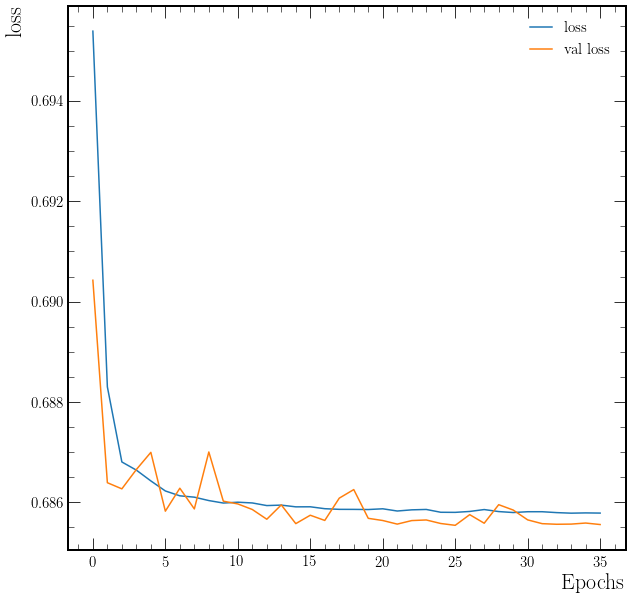

In [113]:
plt.plot(history.history['loss'],     label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend(loc=0)
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.show() 

In [ ]:
import os

import tensorflow as tf
from tensorflow import keras
save_label = 'DCTR_pp_tt_1D_Rb_mine_xB_CP5_nominal'
print(tf.version.VERSION)

dctr = tf.keras.models.load_model('/nfs/dust/cms/user/vaguglie/saved_models_Rb_afs/'+ save_label + '.h5')

# Check its architecture
dctr.summary()

In [ ]:
np.load('weights1valueRealCP5_nominal.npz')
weights_0 = dataset['a'] 
weights_1 = dataset['b'] 
weights_3 = dataset['c']

np.savez_load('X_Test_13TeV_CP5_nominal.npz')
X0_tot = dataset['a']
X1_tot = dataset['b']

In [ ]:
# Define labels for legends
label_1 = r'$R_b=0.855$'

label_0 = r'$R_b = 1.056$'

#pythia_text = r'\textsc{Pythia 8}' + '\n' + r'$e^+e^- \to Z \to $ dijets' +'\n'+ r"anti-$k_{\mathrm{T}}$, $R=0.8$"
pythia_text = r'\textsc{Pythia 8.307}' + '\n' + r'$pp \to $ tt'
def make_legend():
    ax = plt.gca()
    leg = ax.legend(frameon=False)
    leg.set_title(pythia_text, prop={'size':14})
    leg._legend_box.align = "left"
    plt.tight_layout()
    

In [ ]:
## Test part with different samples

In [ ]:
dataset = np.load(data_dir + 'Xb_multC_multNeutra_listBtop_listBextra-Rb_1.056_1M_seed2_CP5.npz')
print(dataset.files)
X0_test = dataset['a']

dataset = np.load(data_dir + 'Xb_multC_multNeutra_listBtop_listBextra-Rb_0.855_1M_seed4_CP5.npz')
print(dataset.files)
X1_test = dataset['a']

In [57]:
print(X0_test.shape)
print(X1_test.shape)

(1900000,)
(1900000,)


In [58]:
X0_test = X0_test[0:1900000]
X1_test = X1_test[0:1900000]

In [59]:
X0_pari = []
X0_dispari = []
X1_pari = []
X1_dispari = []
for i in range (0, 1900000):
    if i % 2 == 0:
        X0_pari.append(X0_test[i])
        X1_pari.append(X1_test[i])
    else:
        X0_dispari.append(X0_test[i])
        X1_dispari.append(X1_test[i])

print(len(X0_pari))
print(len(X1_pari))

print(len(X0_dispari))
print(len(X1_dispari))

950000
950000
950000
950000


In [60]:
X0_tot = []
for i in range (0, 950000):
    X0_tot.append([[X0_pari[i]], [X0_dispari[i]]])

X0_tot = np.array(X0_tot)

print(X0_tot)

X1_tot = []
for i in range (0, 950000):
    X1_tot.append([[X1_pari[i]], [X1_dispari[i]]])

X1_tot = np.array(X1_tot)

print(X1_tot)

print(X0_tot.shape)
print(X1_tot.shape)

[[[0.80564379]
  [0.95529034]]

 [[0.77951907]
  [0.6053596 ]]

 [[0.84170762]
  [0.35722202]]

 ...

 [[0.85792065]
  [0.74644641]]

 [[0.16461302]
  [0.94194006]]

 [[0.70730301]
  [0.81843699]]]
[[[0.73726192]
  [0.60332598]]

 [[0.90034147]
  [0.92143977]]

 [[0.7717229 ]
  [0.66342541]]

 ...

 [[0.65796419]
  [0.88951993]]

 [[0.62755756]
  [0.59909168]]

 [[0.59845086]
  [0.59897335]]]
(950000, 2, 1)
(950000, 2, 1)


In [61]:
# Get predicted probabilities
preds_0 = dctr.predict(X0_tot, batch_size=1000)
preds_1 = dctr.predict(X1_tot, batch_size=1000)

In [62]:
weights_0 = preds_0[:,0]/preds_0[:,1]
weights_1 = preds_1[:,0]/preds_1[:,1]

In [63]:
print(max(weights_0))
print(max(1/weights_0))
print(max(weights_1))
print(max(1/weights_1))

1.3955977
2.6067162
1.3955919
2.5715342


NameError: name 'label_0' is not defined

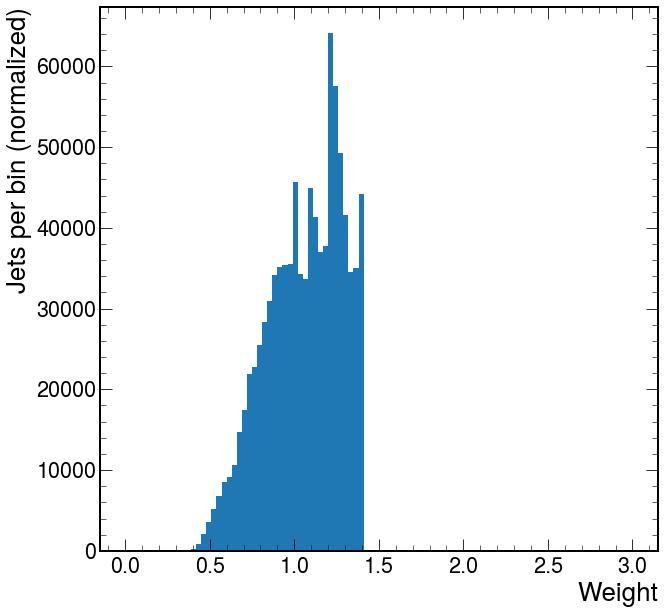

In [64]:
##weight_0
clip_val = 3
bins = np.linspace(0, clip_val, 101)
plt.hist(np.clip(weights_0, 0, clip_val), bins = bins)
plt.xlabel("Weight")
plt.ylabel('Jets per bin (normalized)')
plt.title("Weights " + label_0 + r' $\rightarrow$ ' + label_0, fontsize=20)
plt.yscale('log')
plt.show()

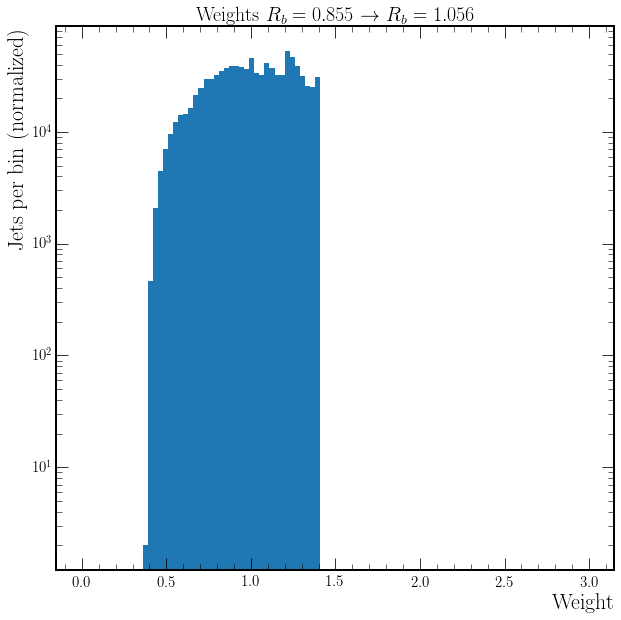

In [126]:
clip_val = 3
bins = np.linspace(0, clip_val, 101)
plt.hist(np.clip(weights_1, 0, clip_val), bins = bins)
plt.yscale('log')
plt.xlabel("Weight")
plt.ylabel('Jets per bin (normalized)')
plt.title("Weights " + label_1 + r' $\rightarrow$ ' + label_0, fontsize=20)
plt.yscale('log')
plt.show()

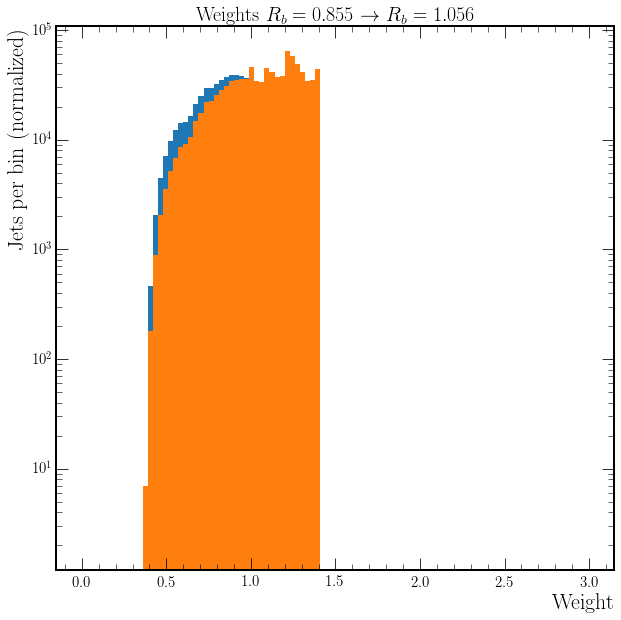

In [127]:
clip_val = 3
bins = np.linspace(0, clip_val, 101)
plt.hist(np.clip(weights_1, 0, clip_val), bins = bins)
plt.hist(np.clip(weights_0, 0, clip_val), bins = bins)
plt.yscale('log')
plt.xlabel("Weight")
plt.ylabel('Jets per bin (normalized)')
plt.title("Weights " + label_1 + r' $\rightarrow$ ' + label_0, fontsize=20)
plt.show()

In [130]:
print(X1_tot.shape)
print(len(weights_1))

(950000, 2, 1)
950000


In [68]:
import mplhep as hep

plt.style.use(hep.style.CMS)

pythia_text = r'$PYTHIA \; pp \to  t\bar{t}$'

from matplotlib.lines import Line2D
def make_legend(ax, title):
    handles, labels = ax.get_legend_handles_labels()
    custom_lines = [Line2D([0], [0], color='black', linestyle='-', linewidth=3),
                    Line2D([0], [0], color='green', linestyle='--', linewidth=3),
                    Line2D([0], [0], color='#FC5A50', linestyle=':', linewidth=3)]
    leg = ax.legend(custom_lines, labels, loc='upper left', frameon=False, title=title)
    leg.get_title().set_fontsize('20')  # Set the font size of the legend title
    for text in leg.get_texts():
        text.set_fontsize('20')  # Set the font size o

/afs/desy.de/user/v/vaguglie/valentina_venv/lib64/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/afs/desy.de/user/v/vaguglie/valentina_venv/lib64/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/afs/desy.de/user/v/vaguglie/valentina_venv/lib64/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/afs/desy.de/user/v/vaguglie/valentina_venv/lib64/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/afs/desy.de/user/v/vaguglie/valentina_venv/lib64/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/afs/desy.de/user/v/vaguglie/valentina_venv/lib64/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in t

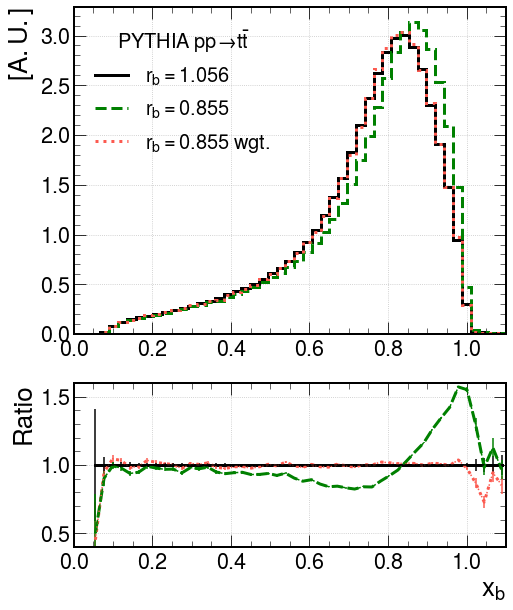

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Define default plot styles
plot_style_10a = {'histtype':'step', 'color':'Green', 'linewidth':3, 'linestyle':'--', 'density':True}
plot_style_11a = {'histtype':'step', 'color':'black', 'linewidth':3, 'linestyle':'-', 'density':True}
plot_style_12a = {'histtype':'step', 'color':'#FC5A50', 'linewidth':3, 'linestyle':':', 'density':True}

# Calculate histograms
hist1, edges1 = np.histogram(X0_tot[:,0,0], bins=50, range=(0, 1.1))
hist2, edges2 = np.histogram(X1_tot[:,0,0], bins=50, range=(0, 1.1))
hist4, edges4 = np.histogram(X1_tot[:,0,0], bins=50, range=(0, 1.1), weights=weights_1)

# Calculate the ratio of the histograms
ratio = hist4 / hist1
ratio_err = np.sqrt(hist4) / hist1
ratioNom = hist1 / hist1
ratio_errNom = np.sqrt(hist1) / hist1
ratioB = hist2 / hist1
ratio_errB = np.sqrt(hist2) / hist1

# Save histogram data, edges, and ratios
np.savez('histogramXbNom.npz', 
         hist1=hist1, edges1=edges1,
         hist2=hist2, edges2=edges2,
         hist4=hist4, edges4=edges4,
         ratio=ratio, ratio_err=ratio_err,
         ratioNom=ratioNom, ratio_errNom=ratio_errNom,
         ratioB=ratioB, ratio_errB=ratio_errB)

# Create figure with two subplots
fig, axes = plt.subplots(nrows=2, figsize=(8, 10), gridspec_kw={'height_ratios': [2, 1]})

# First subplot
bins = np.linspace(0, 1.1, 50)
hist0 = axes[0].hist(X0_tot[:,0,0], bins=bins, label=r'$r_{b}=1.056$', **plot_style_11a)
hist1 = axes[0].hist(X1_tot[:,0,0], bins=bins, label=r'$r_{b}=0.855$', **plot_style_10a)
hist2 = axes[0].hist(X1_tot[:,0,0], bins=bins, label=r'$r_{b}=0.855 \; wgt.$', weights=weights_1, **plot_style_12a)

make_legend(axes[0], pythia_text)
axes[0].set_ylabel(r'$[A.U.]$')
axes[0].grid(True)

# Second subplot
bin_centers = (edges4[:-1] + edges4[1:]) / 2.0
axes[1].errorbar(bin_centers, ratio, yerr=ratio_err, fmt=':', color='#FC5A50')
axes[1].errorbar(bin_centers, ratioNom, yerr=ratio_errNom, fmt='-', color='black')
axes[1].errorbar(bin_centers, ratioB, yerr=ratio_errB, fmt='--', color='green')
axes[1].plot(bin_centers, ratioNom, '-', color='black', linewidth=3)
axes[1].plot(bin_centers, ratio, ':', color='#FC5A50', linewidth=3)
axes[1].plot(bin_centers, ratioB, '--', color='green', linewidth=3)
axes[1].set_xlabel(r'$x_{b}$')
axes[1].set_ylabel('Ratio')
axes[1].grid(True)
axes[1].set_ylim(0.4, 1.60)

axes[0].set_xlim(0., 1.1)
axes[1].set_xlim(0., 1.1)

plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.2, top=0.95)

# Optionally add text and labels
# hep.cms.text("Simulation Preliminary", loc=0, fontsize=20, ax=axes[0])
# axes[0].text(1.0, 1.07, "(13 TeV)", ha="right", va="top", fontsize=20, transform=axes[0].transAxes)

# Save the figure
plt.savefig('/afs/desy.de/user/v/vaguglie/www/NN/PAS/Rb/XbNom_13TeV.pdf')


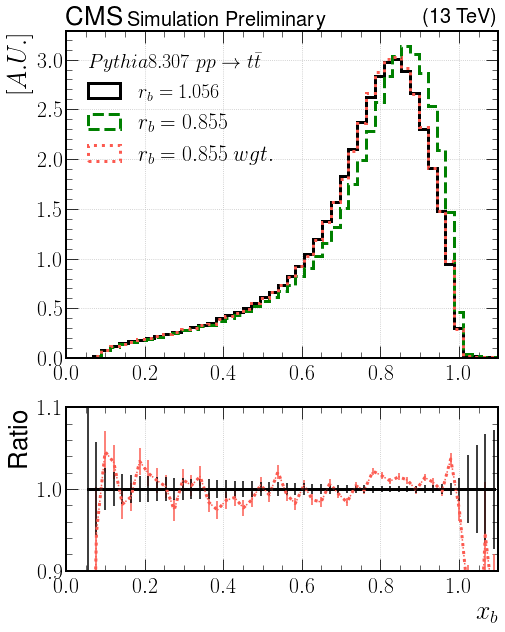

In [136]:
### we have two xB for each event: this is the first Xb ZOOM
    
import matplotlib.pyplot as plt
import numpy as np

# Define default plot styles
plot_style_10a = {'histtype':'step', 'color':'Green', 'linewidth':3, 'linestyle':'--', 'density':True}
plot_style_11a = {'histtype':'step', 'color':'black', 'linewidth':3, 'linestyle':'-', 'density':True}
plot_style_12a = {'histtype':'step', 'color':'#FC5A50', 'linewidth':3, 'linestyle':':', 'density':True}

# Create figure with two subplots
fig, axes = plt.subplots(nrows=2, figsize=(8, 10), gridspec_kw={'height_ratios': [2, 1]})

# First subplot
bins = np.linspace(0, 1.1, 50)
hist0 = axes[0].hist(X0_tot[:,0,0], bins=bins, label=r'$r_{b}=1.056$', **plot_style_11a)
hist1 = axes[0].hist(X1_tot[:,0,0], bins=bins, label=r'$r_{b}=0.855$', **plot_style_10a)
hist2 = axes[0].hist(X1_tot[:,0,0], bins=bins, label=r'$r_{b}=0.855 \; wgt.$', weights=weights_1, **plot_style_12a)

make_legend(axes[0], pythia_text)
axes[0].set_ylabel(r'$[A.U.]$')
axes[0].grid(True)

# Second subplot
bin_centers = (edges4[:-1] + edges4[1:]) / 2.0
axes[1].errorbar(bin_centers, ratio, yerr=ratio_err, fmt=':', color='#FC5A50')
axes[1].errorbar(bin_centers, ratioNom, yerr=ratio_errNom, fmt='-', color='black')
axes[1].plot(bin_centers, ratioNom, '-', color='black',linewidth=3)
axes[1].plot(bin_centers, ratio, ':', color='#FC5A50',linewidth=3)
axes[1].set_xlabel(r'$x_{b}$')
axes[1].set_ylabel('Ratio')
axes[1].grid(True)
axes[1].set_ylim(0.9,1.10)

axes[0].set_xlim(0.,1.1)
axes[1].set_xlim(0.,1.1)

plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.2, top=0.95)

hep.cms.text("Simulation Preliminary", loc=0, fontsize=20, ax=axes[0])
axes[0].text(1.0, 1.07, "(13 TeV)", ha="right", va="top", fontsize=20, transform=axes[0].transAxes)
# Save the figure
plt.savefig('/afs/desy.de/user/v/vaguglie/www/NN/Bfragm13TeVCP5/XbSubPlots_13TeV.pdf')




/afs/desy.de/user/v/vaguglie/valentina_venv/lib64/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/afs/desy.de/user/v/vaguglie/valentina_venv/lib64/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/afs/desy.de/user/v/vaguglie/valentina_venv/lib64/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/afs/desy.de/user/v/vaguglie/valentina_venv/lib64/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/afs/desy.de/user/v/vaguglie/valentina_venv/lib64/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/afs/desy.de/user/v/vaguglie/valentina_venv/lib64/python3.6/site-packages/ipykerne

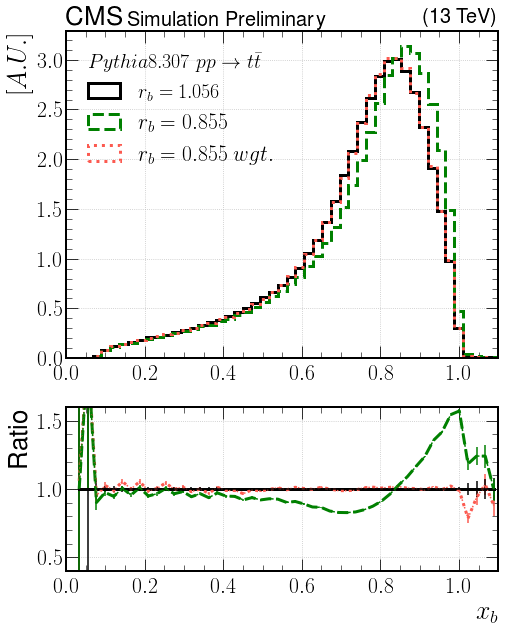

In [137]:
### we have two xB for each event: this is the second Xb 

hist1, edges1 = np.histogram(X0_tot[:,1,0], bins=50, range=(0, 1.1))
hist2, edges2 = np.histogram(X1_tot[:,1,0], bins=50, range=(0, 1.1))
hist4, edges4 = np.histogram(X1_tot[:,1,0], bins=50, range=(0, 1.1),  weights=weights_1)

plt.style.use(hep.style.CMS)

# Calculate the ratio of the histograms
ratio = hist4 / hist1
ratio_err = np.sqrt(hist4) / hist1
# Calculate the ratio of the histograms
ratioNom = hist1 / hist1
ratio_errNom = np.sqrt(hist1) / hist1

# Calculate the ratio of the histograms
ratioB = hist2 / hist1
ratio_errB = np.sqrt(hist2) / hist1

def make_legend(ax, title):
    leg = ax.legend(frameon=False, loc='upper left')
    leg.set_title(title, prop={'size':20})
    leg.texts[0].set_fontsize(20)
    leg._legend_box.align = "left"
    plt.tight_layout()

pythia_text = r'$Pythia 8.307 \; pp \to  t\bar{t}$'

import matplotlib.pyplot as plt
import numpy as np

# Define default plot styles
plot_style_10a = {'histtype':'step', 'color':'Green', 'linewidth':3, 'linestyle':'--', 'density':True}
plot_style_11a = {'histtype':'step', 'color':'black', 'linewidth':3, 'linestyle':'-', 'density':True}
plot_style_12a = {'histtype':'step', 'color':'#FC5A50', 'linewidth':3, 'linestyle':':', 'density':True}

# Create figure with two subplots
fig, axes = plt.subplots(nrows=2, figsize=(8, 10), gridspec_kw={'height_ratios': [2, 1]})

# First subplot
bins = np.linspace(0, 1.1, 50)
hist0 = axes[0].hist(X0_tot[:,1,0], bins=bins, label=r'$r_{b}=1.056$', **plot_style_11a)
hist1 = axes[0].hist(X1_tot[:,1,0], bins=bins, label=r'$r_{b}=0.855$', **plot_style_10a)
hist2 = axes[0].hist(X1_tot[:,1,0], bins=bins, label=r'$r_{b}=0.855 \; wgt.$', weights=weights_1, **plot_style_12a)

make_legend(axes[0], pythia_text)
axes[0].set_ylabel(r'$[A.U.]$')
axes[0].grid(True)

# Second subplot
bin_centers = (edges4[:-1] + edges4[1:]) / 2.0
axes[1].errorbar(bin_centers, ratio, yerr=ratio_err, fmt=':', color='#FC5A50')
axes[1].errorbar(bin_centers, ratioNom, yerr=ratio_errNom, fmt='-', color='black')
axes[1].errorbar(bin_centers, ratioB, yerr=ratio_errB, fmt='--', color='green')
axes[1].plot(bin_centers, ratioNom, '-', color='black',linewidth=3)
axes[1].plot(bin_centers, ratio, ':', color='#FC5A50',linewidth=3)
axes[1].plot(bin_centers, ratioB, '--', color='green',linewidth=3)
axes[1].set_xlabel(r'$x_{b}$')
axes[1].set_ylabel('Ratio')
axes[1].grid(True)
axes[1].set_ylim(0.4,1.60)

axes[0].set_xlim(0.,1.1)
axes[1].set_xlim(0.,1.1)

plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.2, top=0.95)

hep.cms.text("Simulation Preliminary", loc=0, fontsize=20, ax=axes[0])
axes[0].text(1.0, 1.07, "(13 TeV)", ha="right", va="top", fontsize=20, transform=axes[0].transAxes)
# Save the figure
plt.savefig('/afs/desy.de/user/v/vaguglie/www/NN/Bfragm13TeVCP5/XbSubPlots_13TeV.pdf')



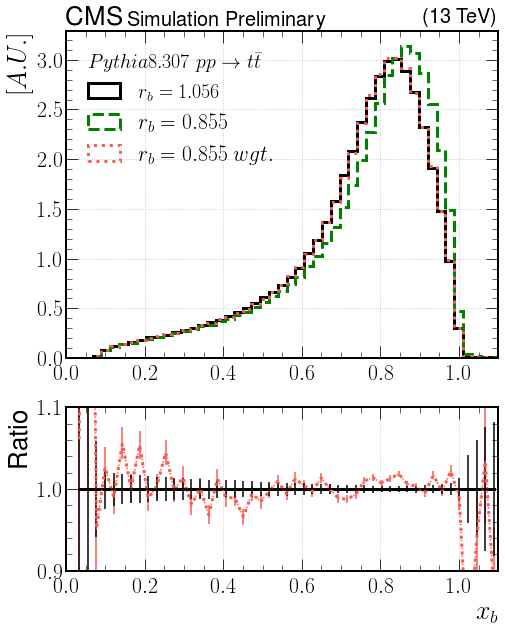

In [138]:
### we have two xB for each event: this is the second Xb, ZOOM 

# Create figure with two subplots
fig, axes = plt.subplots(nrows=2, figsize=(8, 10), gridspec_kw={'height_ratios': [2, 1]})

# First subplot
bins = np.linspace(0, 1.1, 50)
hist0 = axes[0].hist(X0_tot[:,1,0], bins=bins, label=r'$r_{b}=1.056$', **plot_style_11a)
hist1 = axes[0].hist(X1_tot[:,1,0], bins=bins, label=r'$r_{b}=0.855$', **plot_style_10a)
hist2 = axes[0].hist(X1_tot[:,1,0], bins=bins, label=r'$r_{b}=0.855 \; wgt.$', weights=weights_1, **plot_style_12a)

make_legend(axes[0], pythia_text)
axes[0].set_ylabel(r'$[A.U.]$')
axes[0].grid(True)

# Second subplot
bin_centers = (edges4[:-1] + edges4[1:]) / 2.0
axes[1].errorbar(bin_centers, ratio, yerr=ratio_err, fmt=':', color='#FC5A50')
axes[1].errorbar(bin_centers, ratioNom, yerr=ratio_errNom, fmt='-', color='black')
axes[1].plot(bin_centers, ratioNom, '-', color='black',linewidth=3)
axes[1].plot(bin_centers, ratio, ':', color='#FC5A50',linewidth=3)
axes[1].set_xlabel(r'$x_{b}$')
axes[1].set_ylabel('Ratio')
axes[1].grid(True)
axes[1].set_ylim(0.9,1.10)

axes[0].set_xlim(0.,1.1)
axes[1].set_xlim(0.,1.1)

plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.2, top=0.95)

hep.cms.text("Simulation Preliminary", loc=0, fontsize=20, ax=axes[0])
axes[0].text(1.0, 1.07, "(13 TeV)", ha="right", va="top", fontsize=20, transform=axes[0].transAxes)
# Save the figure
plt.savefig('/afs/desy.de/user/v/vaguglie/www/NN/Bfragm13TeVCP5/XbSubPlots_13TeV.pdf')




In [139]:
print(len(weights_1))

950000


In [71]:
w=[]
for i in range (0, 475000):
    w.append(weights_1[i])
print(len(w))

475000


In [72]:
pT = []
Rb = [0.855]


for i in range(0, len(Rb)):
    print('/nfs/dust/cms/user/vaguglie/generators/pythia8307/examples/pT:bfirst_blast_abfirst_ablast_Bpos_Bneg_top_antitop-Rb_%.3f_1M_seed4_CP5.npz'%Rb[i])
    dataset=np.load('/nfs/dust/cms/user/vaguglie/generators/pythia8307/examples/pT:bfirst_blast_abfirst_ablast_Bpos_Bneg_top_antitop-Rb_%.3f_1M_seed4_CP5.npz'%Rb[i])
    print(dataset.files)
    p4_Bpos = dataset['e']
    p4_Bneg = dataset['f']
    pT_Bpos = p4_Bpos[:,0]
    pT_Bneg = p4_Bneg[:,0]
    print(pT_Bpos.shape)
    print(pT_Bneg.shape)
    pT_Bpos = pT_Bpos[0:int(475000)]
    pT_Bneg = pT_Bneg[0:int(475000)]
    print(pT_Bpos.shape)
    print(pT_Bneg.shape)
    pT_tot = np.concatenate((pT_Bpos,pT_Bneg))
    pT.append(pT_tot)

Rb = [1.056]
for i in range(0, len(Rb)):
    print('/nfs/dust/cms/user/vaguglie/generators/pythia8307/examples/pT:bfirst_blast_abfirst_ablast_Bpos_Bneg_top_antitop-Rb_%.3f_1M_seed2_CP5.npz'%Rb[i])
    dataset=np.load('/nfs/dust/cms/user/vaguglie/generators/pythia8307/examples/pT:bfirst_blast_abfirst_ablast_Bpos_Bneg_top_antitop-Rb_%.3f_1M_seed2_CP5.npz'%Rb[i])
    print(dataset.files)
    p4_Bpos = dataset['e']
    p4_Bneg = dataset['f']
    pT_Bpos = p4_Bpos[:,0]
    pT_Bneg = p4_Bneg[:,0]
    print(pT_Bpos.shape)
    print(pT_Bneg.shape)
    pT_Bpos = pT_Bpos[0:int(475000)]
    pT_Bneg = pT_Bneg[0:int(475000)]
    print(pT_Bpos.shape)
    print(pT_Bneg.shape)
    pT_tot = np.concatenate((pT_Bpos,pT_Bneg))
    pT.append(pT_tot)

print(len(pT))

/nfs/dust/cms/user/vaguglie/generators/pythia8307/examples/pT:bfirst_blast_abfirst_ablast_Bpos_Bneg_top_antitop-Rb_0.855_1M_seed4_CP5.npz
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
(996324,)
(996324,)
(475000,)
(475000,)
/nfs/dust/cms/user/vaguglie/generators/pythia8307/examples/pT:bfirst_blast_abfirst_ablast_Bpos_Bneg_top_antitop-Rb_1.056_1M_seed2_CP5.npz
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
(996392,)
(996392,)
(475000,)
(475000,)
2


In [73]:
print(len(pT[0]))
print(len(pT[1]))
print

950000
950000


<function print>

In [74]:
def weights2(peso):
    peso = np.concatenate((peso,peso))
    return peso

In [75]:
weights_3 = weights2(w)

In [76]:
print(len(weights_3))

950000


In [77]:
from matplotlib.lines import Line2D
def make_legend(ax, title):
    handles, labels = ax.get_legend_handles_labels()
    custom_lines = [Line2D([0], [0], color='black', linestyle='-', linewidth=3),
                    Line2D([0], [0], color='green', linestyle='--', linewidth=3),
                    Line2D([0], [0], color='#FC5A50', linestyle=':', linewidth=3)]
    leg = ax.legend(custom_lines, labels, loc='upper right', frameon=False, title=title)
    leg.get_title().set_fontsize('20')  # Set the font size of the legend title
    for text in leg.get_texts():
        text.set_fontsize('20')  # Set the font size o

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


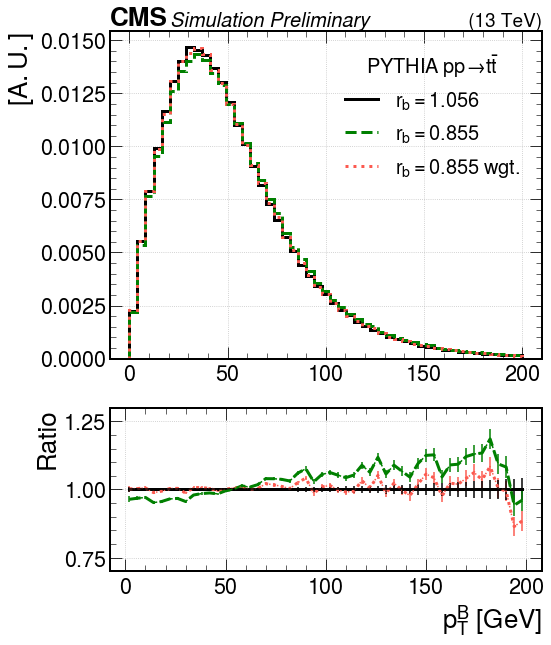

In [83]:
hist1, edges1 = np.histogram(pT[1], bins=50, range=(0, 200))
hist2, edges2 = np.histogram(pT[0], bins=50, range=(0, 200))
hist4, edges4 = np.histogram(pT[0], bins=50, range=(0, 200),  weights=weights_3)

import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

# Calculate the ratio of the histograms
ratio = hist4 / hist1
ratio_err = np.sqrt(hist4) / hist1
# Calculate the ratio of the histograms
ratioNom = hist1 / hist1
ratio_errNom = np.sqrt(hist1) / hist1

# Calculate the ratio of the histograms
ratioB = hist2 / hist1
ratio_errB = np.sqrt(hist2) / hist1

np.savez('histogramPtBNom.npz', 
         hist1=hist1, edges1=edges1,
         hist2=hist2, edges2=edges2,
         hist4=hist4, edges4=edges4,
         ratio=ratio, ratio_err=ratio_err,
         ratioNom=ratioNom, ratio_errNom=ratio_errNom,
         ratioB=ratioB, ratio_errB=ratio_errB)

import matplotlib.pyplot as plt
import numpy as np

# Define default plot styles
plot_style_10a = {'histtype':'step', 'color':'Green', 'linewidth':3, 'linestyle':'--', 'density':True}
plot_style_11a = {'histtype':'step', 'color':'black', 'linewidth':3, 'linestyle':'-', 'density':True}
plot_style_12a = {'histtype':'step', 'color':'#FC5A50', 'linewidth':3, 'linestyle':':', 'density':True}

# Create figure with two subplots
fig, axes = plt.subplots(nrows=2, figsize=(8, 10), gridspec_kw={'height_ratios': [2, 1]})

# First subplot
bins = np.linspace(0, 200, 50)
hist0 = axes[0].hist(pT[1], bins=bins, label=r'$r_{b}=1.056$', **plot_style_11a)
hist1 = axes[0].hist(pT[0], bins=bins, label=r'$r_{b}=0.855$', **plot_style_10a)
hist2 = axes[0].hist(pT[0], bins=bins, label=r'$r_{b}=0.855\; wgt.$', weights=weights_3, **plot_style_12a)

make_legend(axes[0], pythia_text)
axes[0].set_ylabel(r'$[A.U.]$')
axes[0].grid(True)

# Second subplot
bin_centers = (edges4[:-1] + edges4[1:]) / 2.0
axes[1].errorbar(bin_centers, ratio, yerr=ratio_err, fmt=':', color='#FC5A50')
axes[1].errorbar(bin_centers, ratioNom, yerr=ratio_errNom, fmt='-', color='black')
axes[1].errorbar(bin_centers, ratioB, yerr=ratio_errB, fmt='--', color='green')
axes[1].plot(bin_centers, ratioNom, '-', color='black',linewidth=3)
axes[1].plot(bin_centers, ratio, ':', color='#FC5A50',linewidth=3)
axes[1].plot(bin_centers, ratioB, '--', color='green',linewidth=3)
axes[1].set_xlabel(r'$p_{T}^{B} \; [GeV]$')
axes[1].set_ylabel('Ratio')
axes[1].grid(True)
axes[1].set_ylim(0.7,1.30)

plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.2, top=0.95)

hep.cms.label(ax=axes[0], data=False, paper=False, lumi=None, fontsize=20, loc=0)
# Save the figure
plt.savefig('/afs/desy.de/user/v/vaguglie/www/NN/PAS/Rb/pTBNom_13TeV.pdf')


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


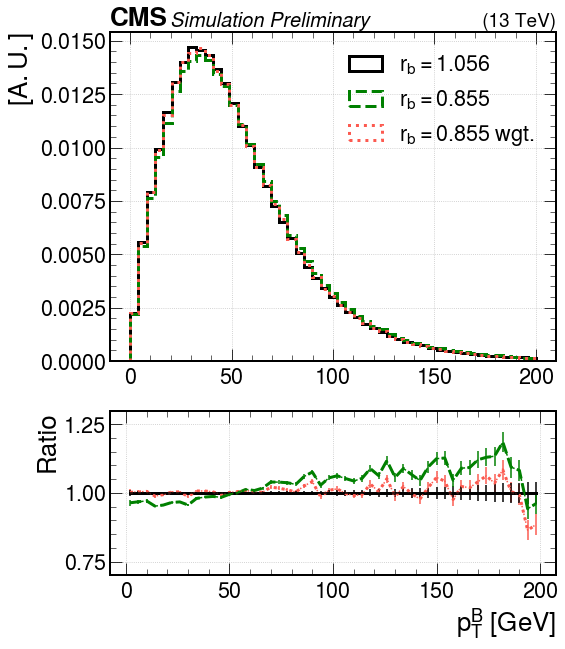

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep

# Genera gli istogrammi
hist1, edges1 = np.histogram(pT[1], bins=50, range=(0, 200))
hist2, edges2 = np.histogram(pT[0], bins=50, range=(0, 200))
hist4, edges4 = np.histogram(pT[0], bins=50, range=(0, 200), weights=weights_3)

# Calcola i rapporti degli istogrammi
ratio = hist4 / hist1
ratio_err = np.sqrt(hist4) / hist1
ratioNom = hist1 / hist1
ratio_errNom = np.sqrt(hist1) / hist1
ratioB = hist2 / hist1
ratio_errB = np.sqrt(hist2) / hist1

# Salva i dati in un file .npz
np.savez('histogramPtBNom.npz',
         hist1=hist1, edges1=edges1,
         hist2=hist2, edges2=edges2,
         hist4=hist4, edges4=edges4,
         ratio=ratio, ratio_err=ratio_err,
         ratioNom=ratioNom, ratio_errNom=ratio_errNom,
         ratioB=ratioB, ratio_errB=ratio_errB)

# Stili di plot
plot_style_10a = {'histtype':'step', 'color':'Green', 'linewidth':3, 'linestyle':'--', 'density':True}
plot_style_11a = {'histtype':'step', 'color':'black', 'linewidth':3, 'linestyle':'-', 'density':True}
plot_style_12a = {'histtype':'step', 'color':'#FC5A50', 'linewidth':3, 'linestyle':':', 'density':True}

# Crea la figura con due subplot
fig, axes = plt.subplots(nrows=2, figsize=(8, 10), gridspec_kw={'height_ratios': [2, 1]})

# Primo subplot (istogrammi)
bins = np.linspace(0, 200, 50)
hist0 = axes[0].hist(pT[1], bins=bins, label=r'$r_{b}=1.056$', **plot_style_11a)
hist1 = axes[0].hist(pT[0], bins=bins, label=r'$r_{b}=0.855$', **plot_style_10a)
hist2 = axes[0].hist(pT[0], bins=bins, weights=weights_3, label=r'$r_{b}=0.855\; wgt.$', **plot_style_12a)

# Aggiungi la legenda al primo subplot
axes[0].legend()
axes[0].set_ylabel(r'$[A.U.]$')
axes[0].grid(True)

# Secondo subplot (rapporti)
bin_centers = (edges4[:-1] + edges4[1:]) / 2.0
axes[1].errorbar(bin_centers, ratio, yerr=ratio_err, fmt=':', color='#FC5A50', label='Ratio w/ weights')
axes[1].errorbar(bin_centers, ratioNom, yerr=ratio_errNom, fmt='-', color='black', label='Ratio Nominal')
axes[1].errorbar(bin_centers, ratioB, yerr=ratio_errB, fmt='--', color='green', label='Ratio B')
axes[1].plot(bin_centers, ratioNom, '-', color='black', linewidth=3)
axes[1].plot(bin_centers, ratio, ':', color='#FC5A50', linewidth=3)
axes[1].plot(bin_centers, ratioB, '--', color='green', linewidth=3)
axes[1].set_xlabel(r'$p_{T}^{B} \; [GeV]$')
axes[1].set_ylabel('Ratio')
axes[1].grid(True)
axes[1].set_ylim(0.7, 1.30)

# Aggiungi etichette CMS al primo subplot
hep.cms.label(ax=axes[0], data=False, paper=False, lumi=None, fontsize=20, loc=0)

# Salva la figura come PDF
plt.savefig('/afs/desy.de/user/v/vaguglie/www/NN/PAS/Rb/pTBNom_13TeV.pdf')

# Mostra il plot (opzionale)
plt.show()


In [33]:
np.savez_compressed('weights1valueRealCP5_nominal.npz', a=weights_0, b=weights_1, c=weights_3)

In [34]:
np.savez_compressed('X_Test_13TeV_CP5_nominal.npz', a=X0_tot, b=X1_tot)